In [3]:
# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

##########  Using gym
import gym

# Scikit-Learn ≥0.20 is required
import sklearn

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

env = gym.make('Acrobot-v1')

env.seed(42)
obs = env.reset()

2023-05-12 13:58:44.214046: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 13:58:44.403858: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-12 13:58:44.478833: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-12 13:58:45.050445: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

## Resolución del problema

Se define un modelo de red neuronal llamado "model" utilizando Keras. Este modelo servirá como la política para tomar decisiones en el entorno.

La red neuronal consta de tres capas:

* Capa de entrada: Una capa completamente conectada con 32 neuronas y una función de activación ReLU. Esta capa toma las observaciones del entorno como entrada.
* Capa oculta: Otra capa completamente conectada con 32 neuronas y una función de activación ReLU.
* Capa de salida: La capa final de la red consta de n_outputs neuronas, donde n_outputs es el número de acciones posibles en el entorno. Se utiliza una función de activación softmax para obtener probabilidades de acción.


In [8]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_inputs = env.observation_space.shape[0]
n_outputs = env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="relu", input_shape=[n_inputs]),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(n_outputs, activation="softmax"),
])

2023-05-12 13:58:45.910649: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-12 13:58:45.931585: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-12 13:58:45.931710: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-12 13:58:45.932262: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [9]:
def bot_play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        loss = tf.reduce_mean(loss_fn(action, probas))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(action[0, 0].numpy())
    return obs, reward, done, grads

def bot_play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = bot_play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

Estas funciones se utilizan para que el agente juegue episodios en el entorno 'Acrobot-v1' utilizando el modelo de la red neuronal y una función de pérdida.

La función bot_play_one_step realiza los siguientes pasos:

* Crea un contexto de GradientTape para calcular los gradientes durante la retropropagación.

* Utiliza el modelo (model) para obtener las probabilidades de acción (probas) a partir de la observación (obs), que se proporciona como entrada a la red neuronal. obs[np.newaxis] se utiliza para agregar una dimensión adicional a la observación para que tenga una forma adecuada para el modelo.

* Calcula los logits (logaritmo de las probabilidades) utilizando tf.math.log() y agrega una pequeña cantidad (keras.backend.epsilon()) para evitar tomar el logaritmo de cero.

* Utiliza tf.random.categorical() para muestrear una acción aleatoria de acuerdo con las distribuciones de probabilidad representadas por los logits. El número de muestras se establece en 1.

* Calcula la pérdida promedio (loss) utilizando la función de pérdida (loss_fn) y comparando la acción elegida con las probabilidades obtenidas.

* Calcula los gradientes de la pérdida con respecto a las variables entrenables del modelo utilizando tape.gradient().

* Toma la acción elegida (action[0, 0].numpy()) y la aplica al entorno (env.step()) para obtener la siguiente observación (obs), la recompensa (reward), si el episodio está terminado (done) y cualquier información adicional (info).

* Retorna la siguiente observación, recompensa, estado de finalización y los gradientes calculados.

La función bot_play_multiple_episodes tiene la siguiente estructura y funcionalidad:

* Inicializa dos listas vacías, all_rewards y all_grads, para almacenar las recompensas y los gradientes de cada episodio, respectivamente.

* Se itera sobre un rango de n_episodes, que representa el número de episodios que el agente va a jugar en el entorno.

* Dentro del bucle de episodios, se inicializan dos listas vacías, current_rewards y current_grads, que almacenarán las recompensas y gradientes del episodio actual.

* Se llama a env.reset() para reiniciar el entorno y obtener la observación inicial (obs).

* Se itera sobre un rango de n_max_steps, que representa el número máximo de pasos que el agente jugará en cada episodio.

* Dentro del bucle de pasos, se llama a bot_play_one_step para realizar un paso del agente en el entorno. Se proporcionan la observación actual (obs), el modelo (model) y la función de pérdida (loss_fn). Esto devuelve la siguiente observación, la recompensa, el estado de finalización y los gradientes.

* Se añade la recompensa del paso actual a la lista current_rewards y los gradientes a la lista current_grads.

* Si el estado de finalización (done) es verdadero, se rompe el bucle de pasos, lo que indica que el episodio ha terminado.

* Después del bucle de pasos, se añaden las listas current_rewards y current_grads a las listas all_rewards y all_grads, respectivamente, para almacenar las recompensas y gradientes del episodio actual.

* Una vez que se han completado todos los episodios, se devuelve all_rewards y all_grads, que contienen las recompensas y gradientes de cada episodio jugado.

* En resumen, la función bot_play_multiple_episodes se encarga de jugar múltiples episodios en el entorno 'Acrobot-v1', recopilando las recompensas y los gradientes de cada episodio. Esto puede ser útil para evaluar el desempeño del agente y realizar el aprendizaje mediante la optimización de la función de pérdida utilizando los gradientes calculados.







In [10]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

Las funciones discount_rewards y discount_and_normalize_rewards están relacionadas con el cálculo y normalización de recompensas descontadas. Estas funciones se utilizan para ajustar la importancia relativa de las recompensas pasadas y futuras y para normalizar las recompensas para un mejor entrenamiento del agente.

In [11]:
n_iterations = 125 
n_episodes_per_update = 8 
n_max_steps = 350 
discount_rate = 0.99

Los parámetros utilizados en el código son los siguientes:

n_iterations: Representa el número total de iteraciones o actualizaciones del agente. Cada iteración implica jugar múltiples episodios y realizar ajustes en el modelo de acuerdo con las recompensas obtenidas. En este caso, se establece en 125 iteraciones.

n_episodes_per_update: Indica el número de episodios jugados por cada actualización del modelo. Después de jugar estos episodios, se calculan las recompensas y los gradientes, y se ajustan los pesos del modelo en función de ellos. En este caso, se establece en 8 episodios por actualización.

n_max_steps: Es el número máximo de pasos que el agente jugará en cada episodio. Si el agente no ha terminado el episodio después de alcanzar este límite, se detendrá y se pasará al siguiente episodio. Aquí, se establece en 350 pasos por episodio.

discount_rate: Es el factor de descuento utilizado para calcular las recompensas descontadas. Determina el peso relativo de las recompensas pasadas y futuras en el proceso de aprendizaje del agente. En este caso, se establece en 0.99, lo que significa que las recompensas futuras se descuentan en un 1% por cada paso en el tiempo.

In [12]:
optimizer = keras.optimizers.Nadam(learning_rate=0.005)
loss_fn = keras.losses.sparse_categorical_crossentropy

In [13]:
env.seed(42)

mean_rewards = []

for iteration in range(n_iterations):
    all_rewards, all_grads = bot_play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    mean_reward = sum(map(sum, all_rewards)) / n_episodes_per_update
    print("\rIteration: {}/{}, mean reward: {:.1f}  ".format(
        iteration + 1, n_iterations, mean_reward), end="")
    mean_rewards.append(mean_reward)
    
    if len(mean_rewards)%5 ==0:
        with open('mean_rewards.txt', 'a') as ouputFile:
            for reward in mean_rewards:
                ouputFile.write(str(reward))
                ouputFile.write('\n')
        mean_rewards = []
    
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                    discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
            for episode_index, final_rewards in enumerate(all_final_rewards)
                for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

2023-05-12 13:58:47.335630: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Iteration: 125/125, mean reward: -79.0   

Por último, se implementa el bucle principal de entrenamiento. Aquí se realiza la iteración a lo largo de las n iteraciones y se actualizan los pesos del modelo en función de las recompensas obtenidas. En cada iteración, se llama a la función bot_play_multiple_episodes para jugar múltiples episodios (n_episodes_per_update) y recopilar las recompensas y los gradientes obtenidos. Los argumentos proporcionados son el entorno (env), el número máximo de pasos por episodio (n_max_steps), el modelo (model) y la función de pérdida (loss_fn). Las recompensas y gradientes se asignan a las variables all_rewards y all_grads, respectivamente. Se calcula la recompensa promedio por episodio (mean_reward). Para ello, se suman todas las recompensas de cada episodio en all_rewards y se divide por n_episodes_per_update. Para evitar el overload de la RAM cada 5 iteraciones, se guarda el contenido de la lista mean_rewards en un archivo de texto llamado 'mean_rewards.txt'. Luego, se vacía la lista mean_rewards para comenzar a recopilar las recompensas promedio de las siguientes iteraciones.

[-334.0, -333.375, -346.25, -345.25, -350.0, -350.0, -350.0, -348.375, -344.125, -322.125, -327.5, -334.75, -349.25, -341.5, -333.25, -350.0, -348.75, -312.125, -338.125, -296.625, -329.375, -347.375, -347.125, -326.0, -290.875, -275.125, -284.625, -252.5, -230.75, -188.125, -208.875, -182.75, -173.875, -186.875, -140.25, -118.75, -127.5, -128.0, -115.0, -129.5, -111.75, -111.125, -95.0, -120.75, -108.375, -99.75, -109.75, -118.875, -102.375, -97.875, -107.375, -100.0, -102.25, -107.875, -101.125, -105.5, -113.125, -92.125, -105.5, -112.125, -101.0, -121.375, -99.5, -107.375, -116.0, -103.125, -124.25, -111.75, -93.25, -87.75, -89.375, -90.875, -96.75, -109.25, -101.75, -108.0, -90.25, -120.75, -111.875, -90.25, -80.625, -83.5, -83.875, -82.75, -93.875, -79.125, -106.5, -109.75, -98.25, -83.5, -82.25, -116.375, -85.625, -90.5, -92.875, -88.5, -106.375, -89.125, -102.625, -90.625, -96.125, -89.875, -81.875, -94.5, -106.875, -102.5, -97.625, -101.375, -90.5, -87.25, -97.875, -88.375, -10

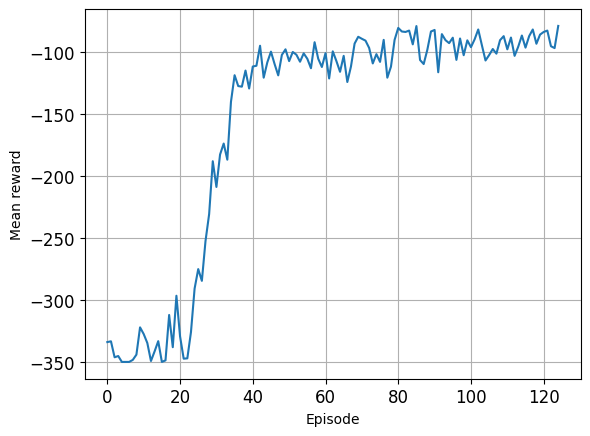

In [14]:
import matplotlib.pyplot as plt

def leer_archivo(nombre_archivo):
    numeros = []  # Array para almacenar los números

    # Abrir el archivo en modo lectura
    with open(nombre_archivo, 'r') as archivo:
        # Leer cada línea del archivo
        for linea in archivo:
            # Convertir la línea en un número y agregarlo al array
            numero = float(linea.strip()) # Suponiendo que cada línea contiene un número entero
            #numero = float(numero)
            numeros.append(numero)

    return numeros

# Llamar a la función y proporcionar el nombre del archivo
nombre_archivo = 'mean_rewards.txt'
mean_rewards = leer_archivo(nombre_archivo)

# Imprimir el array de números
print(mean_rewards)

plt.plot(mean_rewards)
plt.xlabel("Episode")
plt.ylabel("Mean reward")
plt.grid()
plt.show()

En este gráfico se puede observar como a partir de la iteración 40 se estabilizan las mean_rewards. Esto sugiere que el agente ha alcanzado un nivel de rendimiento estable en el entorno y ha aprendido una política que le permite obtener recompensas consistentes.

In [15]:
def lander_render_policy_net(model, n_max_steps=500, seed=42):
    frames = []
    env = gym.make("Acrobot-v1")
    env.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        obs, reward, done, info = env.step(action[0, 0].numpy())
        if done:
            break
    env.close()
    return frames

In [16]:
# Now show the animation:

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [17]:
frames = lander_render_policy_net(model, seed=42)
plot_animation(frames)

En la animación se ve como el brazo es capaz de acelerarse y llegar a tocar la línea final.